### Requirement

In [21]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

import pandas as pd

---

#### Data 준비

- 의류(parent_category) 중 max 3350개씩 샘플링한 카테고리중 가장 많은 이미지를 보유하고 있는 카테고리 찾기

In [2]:
path = f'C:/Users/sanghui/Desktop/toyproject/DL_Project_5/hsh/data/crop_resize/train/2'

max = len(os.listdir(f'{path}/11'))

for category_id in os.listdir(path):
    if len(os.listdir(f'{path}/{category_id}')) >= max:
        max_category_id = category_id

max_category_id, len(os.listdir(f'{path}/{max_category_id}'))

('39', 3134)

In [3]:
max_path = f'C:/Users/sanghui/Desktop/toyproject/DL_Project_5/hsh/data/crop_resize/train/2/{max_category_id}'

In [4]:
# load data
samples = []

for image in os.listdir(max_path):
    path = max_path + '/' + image
    src = cv2.imread(path, cv2.IMREAD_COLOR)
    samples.append(src)

samples = np.array(samples)
samples.shape

(3134, 224, 224, 3)

----

### Modeling

#### VGG16

In [10]:
base_model = VGG16(weights='imagenet', include_top=True)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

In [12]:
samples[0].shape

(224, 224, 3)

In [13]:
# feature extraction test
img_data = np.expand_dims(samples[0], axis=0)
img_data = preprocess_input(img_data)

vgg16_features = model.predict(img_data)

vgg16_features.shape


(1, 4096)

In [16]:
vgg16_features[0]

array([ 0.       ,  0.       ,  0.       , ..., 13.419567 ,  0.       ,
       10.5069685], dtype=float32)

In [17]:
# whole data
features = []

for sample in tqdm_notebook(samples):
    img_data = np.expand_dims(sample, axis=0)
    img_data = preprocess_input(img_data)

    features.append(model.predict(img_data)[0])

C:\Users\sanghui\AppData\Local\Temp/ipykernel_10860/2798714378.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm_notebook(samples):


  0%|          | 0/3134 [00:00<?, ?it/s]

In [19]:
# calculate cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(features, features)
cosine_sim.shape

(3134, 3134)

In [22]:
vgg16_result = pd.DataFrame(cosine_sim, columns=os.listdir(max_path), index=os.listdir(max_path))

In [23]:
vgg16_result.head()

0.jpg     1.jpg    10.jpg   100.jpg  1000.jpg  1001.jpg  \
0.jpg     1.000000  0.375351  0.261888  0.738329  0.333565  0.274307   
1.jpg     0.375351  1.000000  0.463320  0.359859  0.342365  0.329104   
10.jpg    0.261888  0.463320  1.000000  0.330885  0.391816  0.353430   
100.jpg   0.738329  0.359859  0.330885  1.000000  0.382481  0.319617   
1000.jpg  0.333565  0.342365  0.391816  0.382481  1.000000  0.304297   

          1002.jpg  1003.jpg  1004.jpg  1005.jpg  ...   990.jpg   991.jpg  \
0.jpg     0.284259  0.150765  0.389495  0.267152  ...  0.275050  0.327296   
1.jpg     0.260270  0.104841  0.469341  0.499791  ...  0.304857  0.445052   
10.jpg    0.338961  0.143989  0.356078  0.572879  ...  0.321170  0.411480   
100.jpg   0.291781  0.166516  0.456202  0.293240  ...  0.275434  0.319786   
1000.jpg  0.372040  0.195219  0.338781  0.349110  ...  0.390114  0.326053   

           992.jpg   993.jpg   994.jpg   995.jpg   996.jpg   997.jpg  \
0.jpg     0.747292  0.541403  0.289302  0.250939  0.188833  0.256985   
1.jpg     0.391862  0.366084  0.483854  0.313011  0.217681  0.146438   
10.jpg    0.338016  0.317627  0.510080  0.395243  0.271309  0.141949   
100.jpg   0.808818  0.598480  0.312091  0.316899  0.229331  0.221056   
1000.jpg  0.337447  0.419777  0.504264  0.491896  0.333379  0.202227   

           998.jpg   999.jpg  
0.jpg     0.424455  0.315173  
1.jpg     0.337827  0.447529  
10.jpg    0.296578  0.516686  
100.jpg   0.512132  0.299169  
1000.jpg  0.295330  0.314070  

[5 rows x 3134 columns]

In [44]:
# random sampleing
random_samples = np.random.choice(os.listdir(max_path), 5)
random_samples

array(['2583.jpg', '1897.jpg', '1485.jpg', '1238.jpg', '851.jpg'],
      dtype='<U9')

In [45]:
vgg16_result[random_samples[0]].sort_values(ascending=False)[:5]

2583.jpg    1.000000
1783.jpg    0.607307
2667.jpg    0.595972
1018.jpg    0.590703
1479.jpg    0.587702
Name: 2583.jpg, dtype: float32

In [49]:
sim_list = list(zip(vgg16_result[random_samples[0]].sort_values(ascending=False)[1:5].index, vgg16_result[random_samples[0]].sort_values(ascending=False)[1:5].values))

In [50]:
sim_list

[('1783.jpg', 0.6073072),
 ('2667.jpg', 0.59597176),
 ('1018.jpg', 0.59070337),
 ('1479.jpg', 0.5877017)]

In [80]:
def show_sim_image(item):
    origin_path = max_path + '/' + item
    plt.figure(figsize=(15, 15))
    src = cv2.imread(origin_path, cv2.IMREAD_COLOR)
    src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, 1)
    plt.imshow(src)
    plt.title('origin')
    plt.axis('off')

    sim_list = list(zip(vgg16_result[item].sort_values(ascending=False)[1:5].index, vgg16_result[item].sort_values(ascending=False)[1:5].values))

    for j, values in enumerate(sim_list):
        sim_path = max_path + '/' + values[0]
        plt.subplot(1, 5, j + 2)
        sim = cv2.imread(sim_path, cv2.IMREAD_COLOR)
        sim = cv2.cvtColor(sim, cv2.COLOR_BGR2RGB)
        plt.imshow(sim)
        plt.title(f'similiar {j+1}: {values[1]: .4f}')
        plt.axis('off')
    plt.show()
    
    

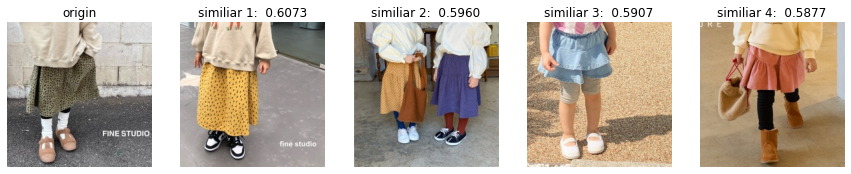

In [81]:
show_sim_image('2583.jpg')

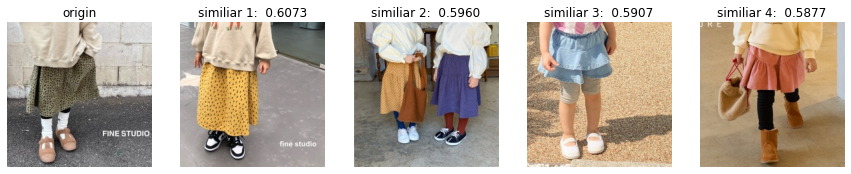

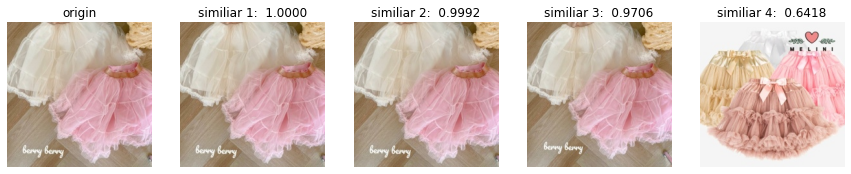

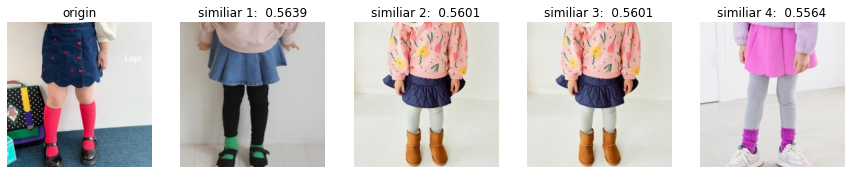

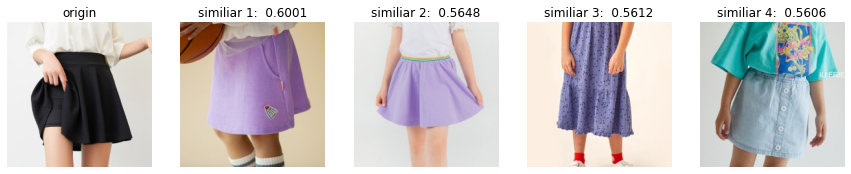

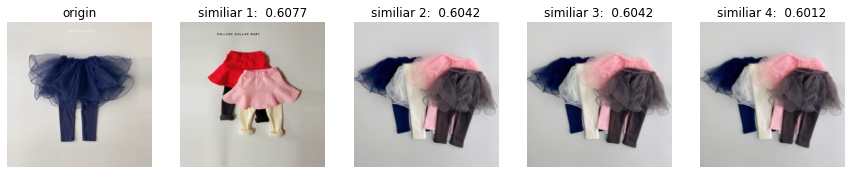

In [82]:
for filename in random_samples:
    show_sim_image(filename)
    print('\n')

In [83]:
# random sampleing
random_samples = np.random.choice(os.listdir(max_path), 10)
random_samples

array(['2158.jpg', '798.jpg', '2837.jpg', '283.jpg', '372.jpg', '211.jpg',
       '862.jpg', '2292.jpg', '737.jpg', '3102.jpg'], dtype='<U9')

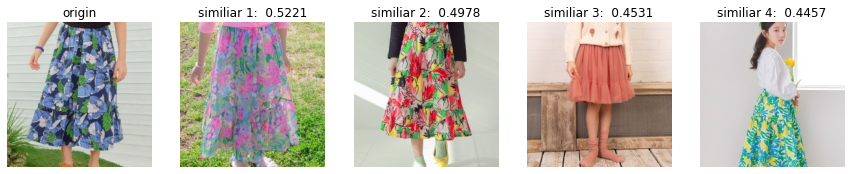

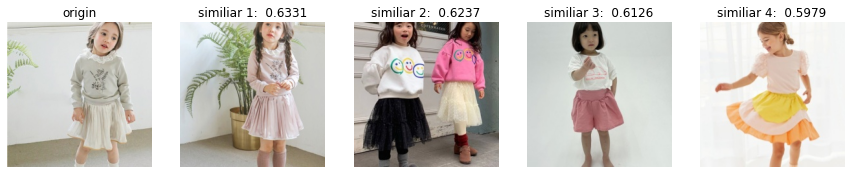

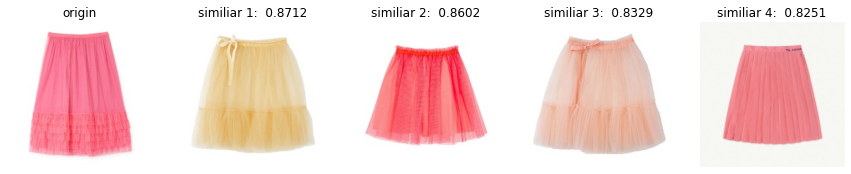

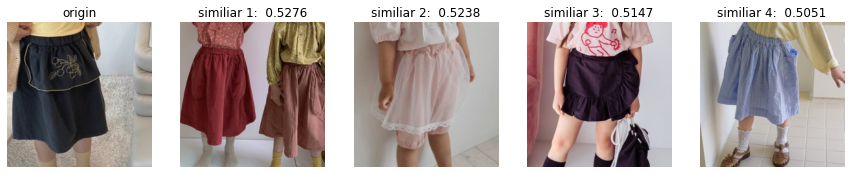

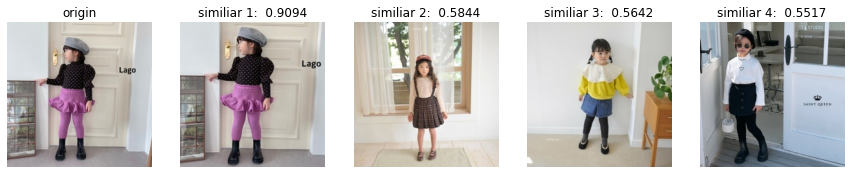

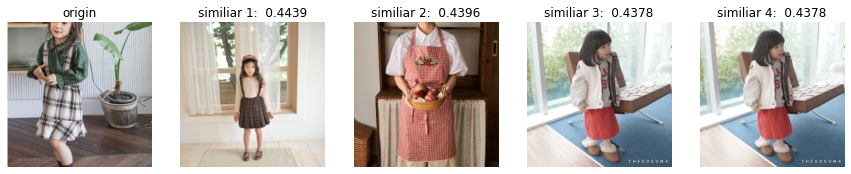

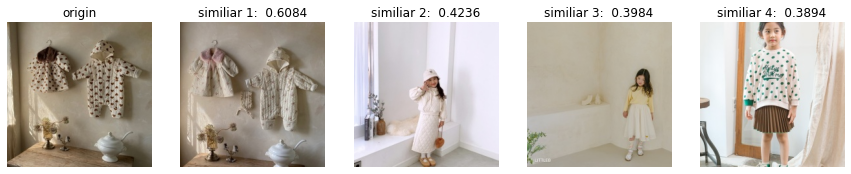

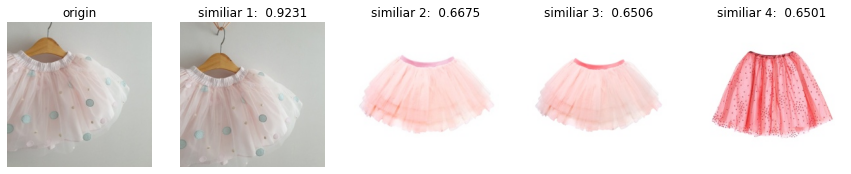

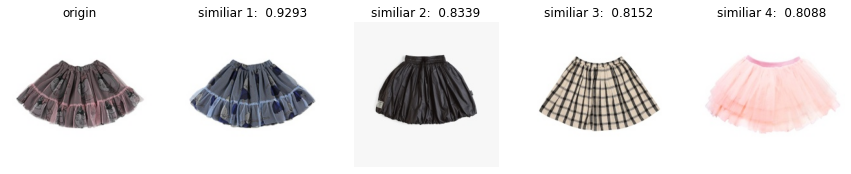

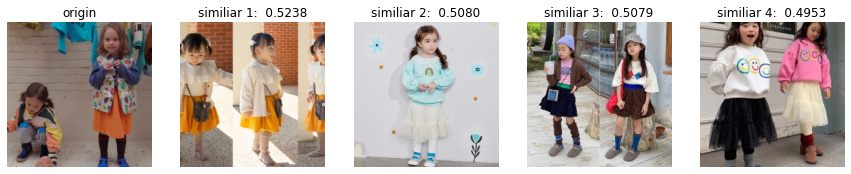

In [84]:
for filename in random_samples:
    show_sim_image(filename)
    print('\n')

---

#### VGG19

In [85]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

base_model2 = VGG19(weights='imagenet', include_top=True)
base_model2.summary()

574726144/574710816 [==============================] - 18s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [87]:
model_vgg19 = Model(inputs=base_model2.input, outputs=base_model2.get_layer('fc1').output)

In [88]:
vgg19_features = []

for sample in tqdm_notebook(samples):
    img_data = np.expand_dims(sample, axis=0)
    img_data = preprocess_input(img_data)

    vgg19_features.append(model_vgg19.predict(img_data)[0])

C:\Users\sanghui\AppData\Local\Temp/ipykernel_10860/69402253.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm_notebook(samples):


  0%|          | 0/3134 [00:00<?, ?it/s]

In [89]:
cosine_sim_vgg19 = cosine_similarity(vgg19_features, vgg19_features)

vgg19_result = pd.DataFrame(cosine_sim_vgg19, columns=os.listdir(max_path), index=os.listdir(max_path))

In [90]:
def show_sim_image_vgg19(item):
    origin_path = max_path + '/' + item
    plt.figure(figsize=(15, 15))
    src = cv2.imread(origin_path, cv2.IMREAD_COLOR)
    src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, 1)
    plt.imshow(src)
    plt.title('origin')
    plt.axis('off')

    sim_list = list(zip(vgg19_result[item].sort_values(ascending=False)[1:5].index, vgg19_result[item].sort_values(ascending=False)[1:5].values))

    for j, values in enumerate(sim_list):
        sim_path = max_path + '/' + values[0]
        plt.subplot(1, 5, j + 2)
        sim = cv2.imread(sim_path, cv2.IMREAD_COLOR)
        sim = cv2.cvtColor(sim, cv2.COLOR_BGR2RGB)
        plt.imshow(sim)
        plt.title(f'similiar {j+1}: {values[1]: .4f}')
        plt.axis('off')
    plt.show()
    
    

In [91]:
random_samples

array(['2158.jpg', '798.jpg', '2837.jpg', '283.jpg', '372.jpg', '211.jpg',
       '862.jpg', '2292.jpg', '737.jpg', '3102.jpg'], dtype='<U9')

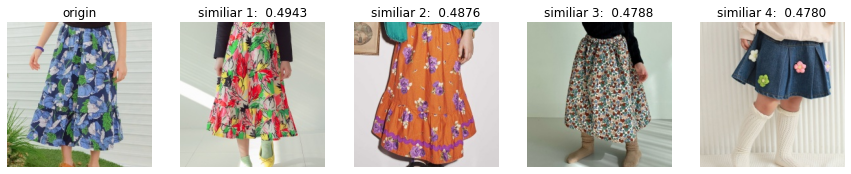

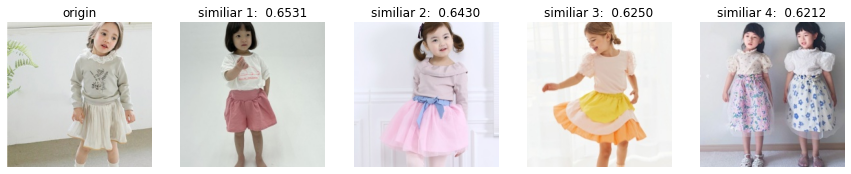

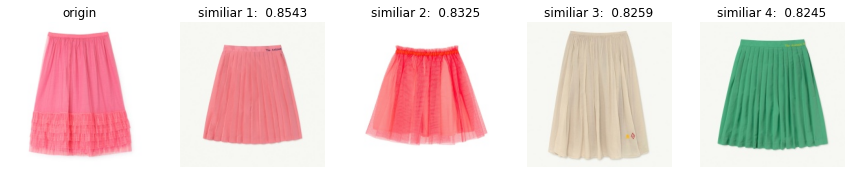

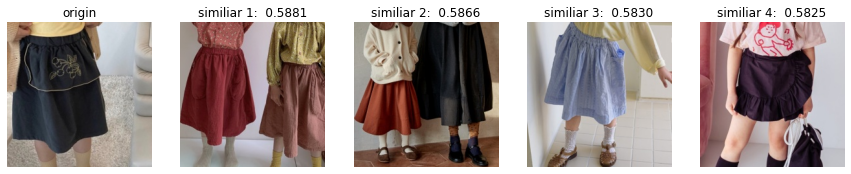

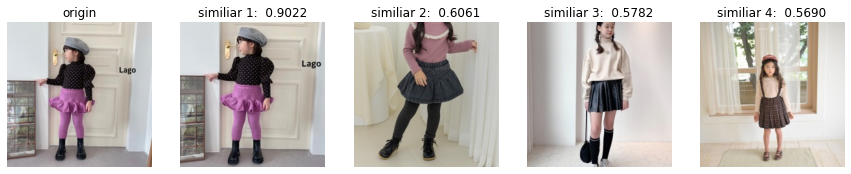

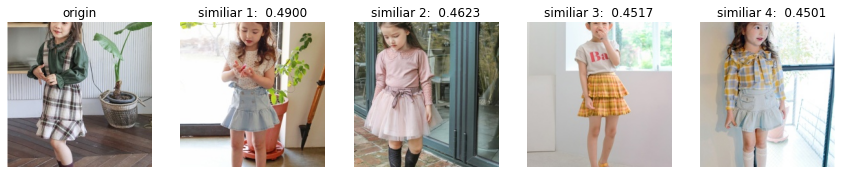

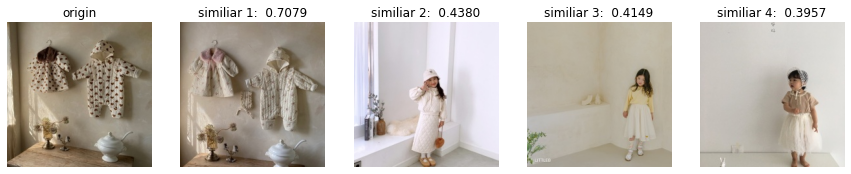

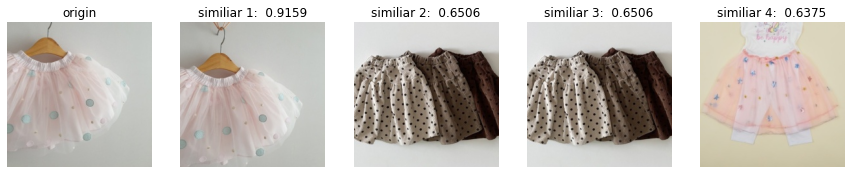

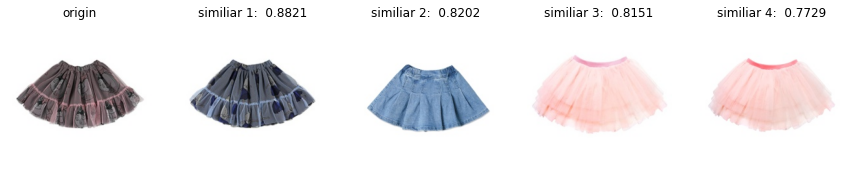

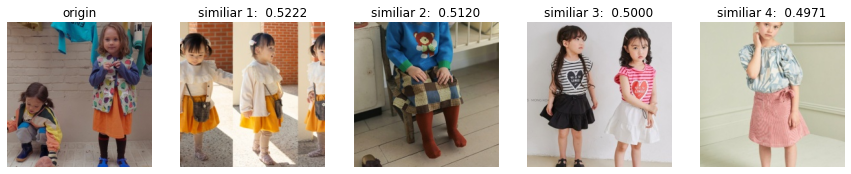

In [92]:
for filename in random_samples:
    show_sim_image_vgg19(filename)
    print('\n')

### Resnet50

In [108]:
from tensorflow.keras.applications.resnet50  import ResNet50 , preprocess_input

resnet50_base = ResNet50 (weights='imagenet', include_top=True)
resnet50_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_10[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [109]:
model_resnet50 = Model(inputs=resnet50_base.input, outputs=resnet50_base.get_layer('avg_pool').output)

In [110]:
resnet_50_features = []

for sample in tqdm_notebook(samples):
    img_data = np.expand_dims(sample, axis=0)
    img_data = preprocess_input(img_data)

    resnet_50_features.append(model_resnet50.predict(img_data)[0])

C:\Users\sanghui\AppData\Local\Temp/ipykernel_10860/2987000388.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm_notebook(samples):


  0%|          | 0/3134 [00:00<?, ?it/s]

In [111]:
cosine_sim_resnet50 = cosine_similarity(resnet_50_features, resnet_50_features)

resnet50_result = pd.DataFrame(cosine_sim_resnet50, columns=os.listdir(max_path), index=os.listdir(max_path))

In [112]:
def show_sim_image_resnet50(item):
    origin_path = max_path + '/' + item
    plt.figure(figsize=(15, 15))
    src = cv2.imread(origin_path, cv2.IMREAD_COLOR)
    src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, 1)
    plt.imshow(src)
    plt.title('origin')
    plt.axis('off')

    sim_list = list(zip(resnet50_result[item].sort_values(ascending=False)[1:5].index, resnet50_result[item].sort_values(ascending=False)[1:5].values))

    for j, values in enumerate(sim_list):
        sim_path = max_path + '/' + values[0]
        plt.subplot(1, 5, j + 2)
        sim = cv2.imread(sim_path, cv2.IMREAD_COLOR)
        sim = cv2.cvtColor(sim, cv2.COLOR_BGR2RGB)
        plt.imshow(sim)
        plt.title(f'similiar {j+1}: {values[1]: .4f}')
        plt.axis('off')
    plt.show()
    
    

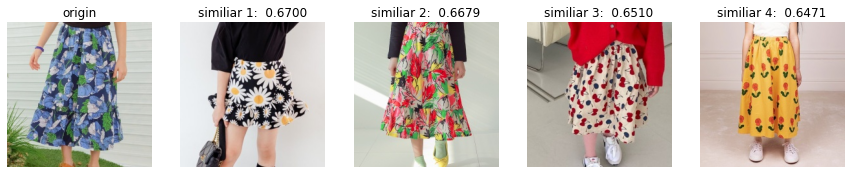

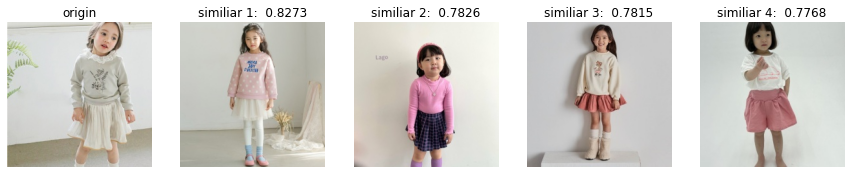

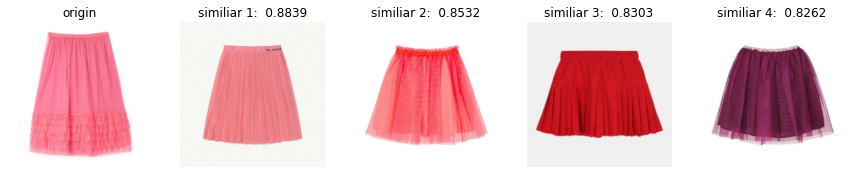

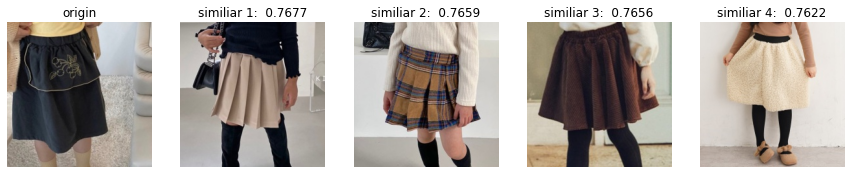

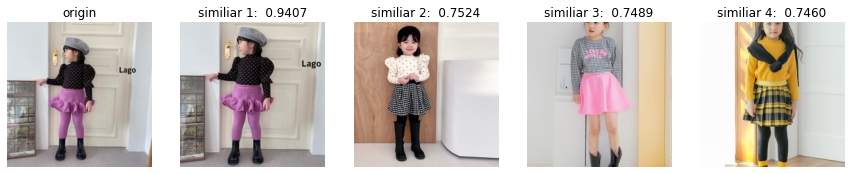

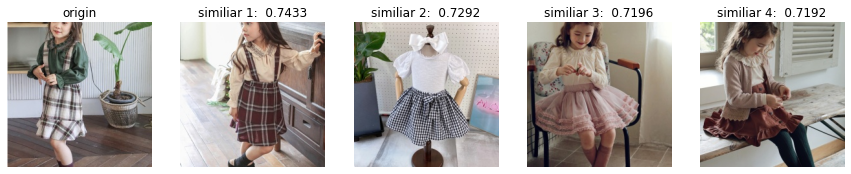

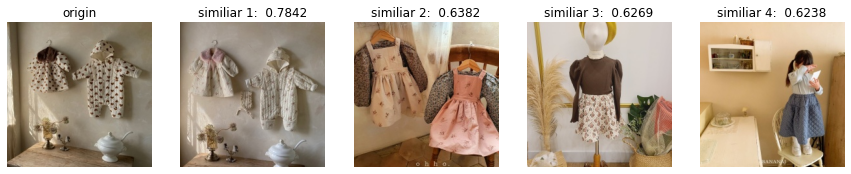

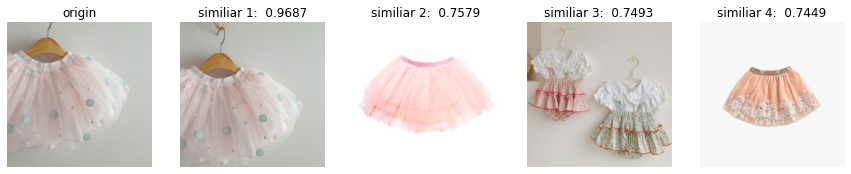

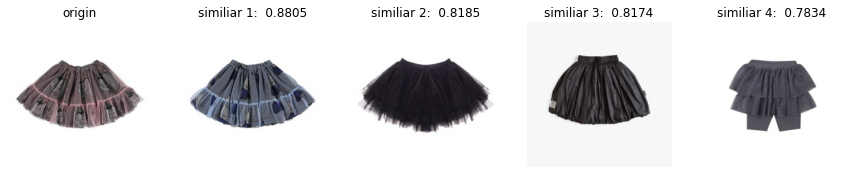

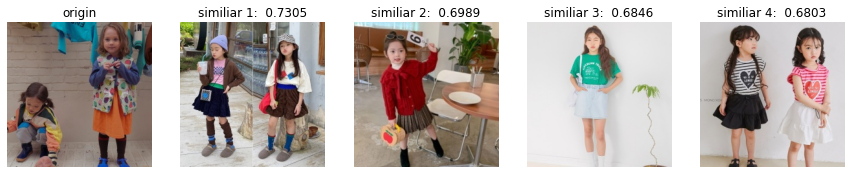

In [113]:
for filename in random_samples:
    show_sim_image_resnet50(filename)
    print('\n')

#### InceptionV3

In [115]:
from tensorflow.keras.applications.inception_v3  import InceptionV3 , preprocess_input

inception_v3_base = InceptionV3 (weights='imagenet', include_top=True)
inception_v3_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 149, 149, 32  864         ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_282 (Batch  (None, 149, 149, 32  96         ['conv2d_282[0][0]']             
 Normalization)                 )                                                      

In [116]:
inception_v3_model = Model(inputs=inception_v3_base.input, outputs=inception_v3_base.get_layer('avg_pool').output)

In [120]:
# load data
samples_resize = []

for image in tqdm_notebook(os.listdir(max_path)):
    path = max_path + '/' + image
    src = cv2.imread(path, cv2.IMREAD_COLOR)
    dst = cv2.resize(src, dsize=(299,299), interpolation=cv2.INTER_CUBIC) #상대적으로 선명한 이미지를 위하여
    samples_resize.append(dst)

samples_resize = np.array(samples_resize)
samples_resize.shape

C:\Users\sanghui\AppData\Local\Temp/ipykernel_10860/2526175083.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for image in tqdm_notebook(os.listdir(max_path)):


  0%|          | 0/3134 [00:00<?, ?it/s]

(3134, 299, 299, 3)

In [121]:
inception_v3_features = []

for sample in tqdm_notebook(samples_resize):
    img_data = np.expand_dims(sample, axis=0)
    img_data = preprocess_input(img_data)

    inception_v3_features.append(inception_v3_model.predict(img_data)[0])

cosine_sim_inceptionv3 = cosine_similarity(inception_v3_features, inception_v3_features)

inceptionv3_result = pd.DataFrame(cosine_sim_inceptionv3, columns=os.listdir(max_path), index=os.listdir(max_path))

C:\Users\sanghui\AppData\Local\Temp/ipykernel_10860/309181350.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm_notebook(samples_resize):


  0%|          | 0/3134 [00:00<?, ?it/s]

In [122]:
def show_sim_image_inceptionv3(item):
    origin_path = max_path + '/' + item
    plt.figure(figsize=(15, 15))
    src = cv2.imread(origin_path, cv2.IMREAD_COLOR)
    src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, 1)
    plt.imshow(src)
    plt.title('origin')
    plt.axis('off')

    sim_list = list(zip(inceptionv3_result[item].sort_values(ascending=False)[1:5].index, inceptionv3_result[item].sort_values(ascending=False)[1:5].values))

    for j, values in enumerate(sim_list):
        sim_path = max_path + '/' + values[0]
        plt.subplot(1, 5, j + 2)
        sim = cv2.imread(sim_path, cv2.IMREAD_COLOR)
        sim = cv2.cvtColor(sim, cv2.COLOR_BGR2RGB)
        plt.imshow(sim)
        plt.title(f'similiar {j+1}: {values[1]: .4f}')
        plt.axis('off')
    plt.show()
    
    

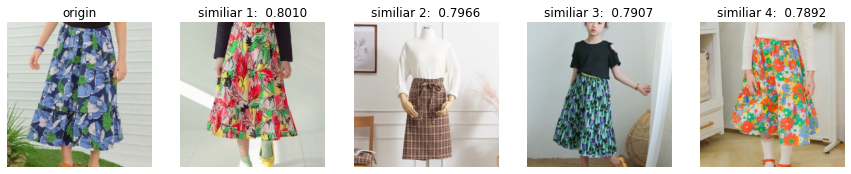

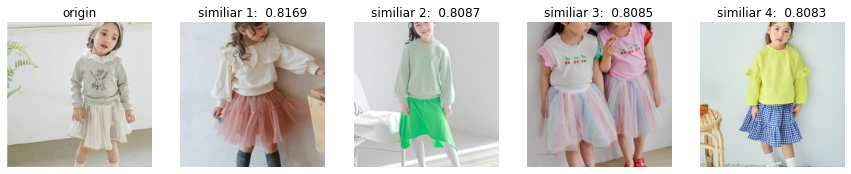

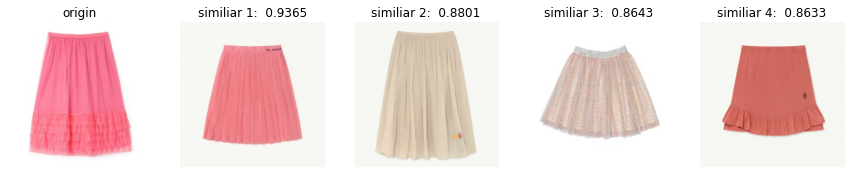

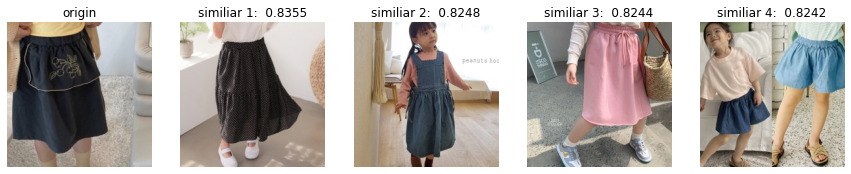

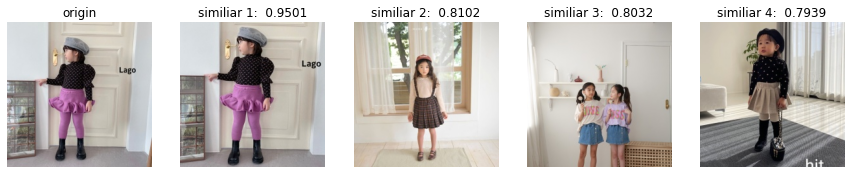

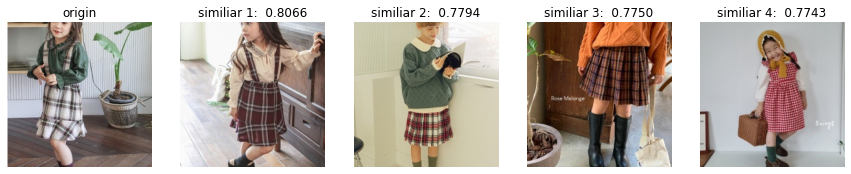

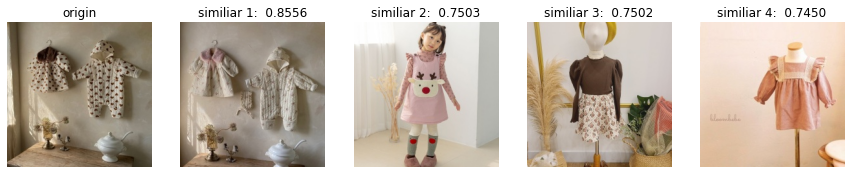

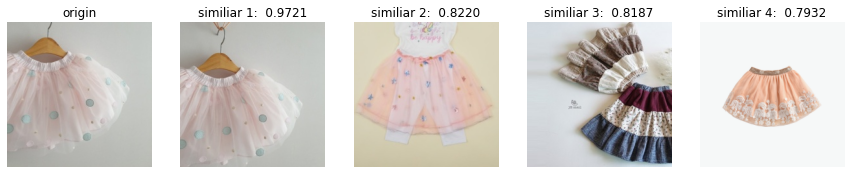

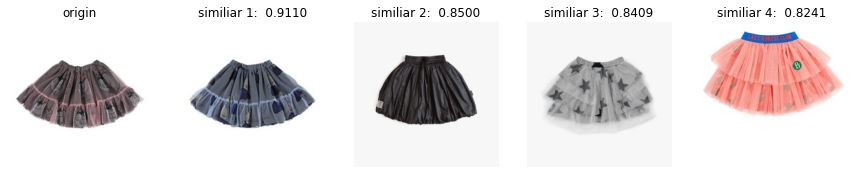

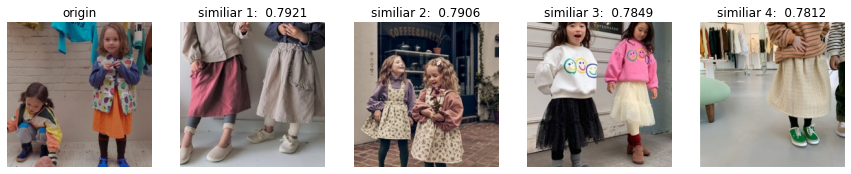

In [123]:
for filename in random_samples:
    show_sim_image_inceptionv3(filename)
    print('\n')